In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_
from spikingjelly.clock_driven.neuron import MultiStepLIFNode
# from spikingjelly.activation_based.neuron import LIFNode

import math

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, embed_dim=192, img_size=32, patch_size=4, drop_rate=0.1):
        super().__init__()
        self.img_size = img_size # 32
        self.patch_size = patch_size # 4
        self.num_patches = (img_size // patch_size) ** 2 # 8*8 = 64
        self.embed_dim = embed_dim # 192
        self.dropout = nn.Dropout(drop_rate) # 0.1
        
        self.project = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
        
        self.class_token = nn.Parameter(th.zeros(1, 1, embed_dim)) # (1, 1, 192)
        self.num_patches += 1 # 65
        self.positional_embedding = nn.Parameter(th.zeros(1, self.num_patches, embed_dim)) # (1, 65, 192)
        
        nn.init.normal_(self.class_token, std=0.02) # class_token 초기화
        trunc_normal_(self.positional_embedding, std=.02) # positional_embedding 초기화

    def forward(self, x):
        T, B, C, H, W = x.shape # T: time_steps, B: batch_size, C: in_channels, H: img_size, W: img_size
        x = x.flatten(0, 1) # (T*B, C, H, W): (4*32, 3, 32, 32)
        x = self.project(x) # (T*B, embed_dim, num_patches**0.5, num_patches**0.5): (128, 192, 8, 8)
        x = x.flatten(2) # (T*B, embed_dim, num_patches): (128, 192, 64)
        x = x.transpose(1, 2) # (T*B, num_patches, embed_dim): (128, 64, 192)
        x = x.reshape(T, B, -1, self.embed_dim) # (T, B, num_patches, embed_dim): (4, 32, 64, 192)
        
        class_tokens = self.class_token.expand(T, B, -1, -1) # (T, B, 1, embed_dim): (4, 32, 1, 192)
        x = th.cat((class_tokens, x), dim=2) # (T, B, num_patches + 1, embed_dim): (4, 32, 65, 192)
        
        x += self.positional_embedding # (T, B, num_patches + 1, embed_dim): (4, 32, 65, 192)
        x = self.dropout(x)
        return x

class SSA(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."
        self.dim = dim
        self.num_heads = num_heads
        self.scale = 0.125
        self.q_linear = nn.Linear(dim, dim)
        self.q_bn = nn.BatchNorm1d(dim)
        self.q_lif = MultiStepLIFNode(tau=2.0, detach_reset=True, backend='torch')

        self.k_linear = nn.Linear(dim, dim)
        self.k_bn = nn.BatchNorm1d(dim)
        self.k_lif = MultiStepLIFNode(tau=2.0, detach_reset=True, backend='torch')

        self.v_linear = nn.Linear(dim, dim)
        self.v_bn = nn.BatchNorm1d(dim)
        self.v_lif = MultiStepLIFNode(tau=2.0, detach_reset=True, backend='torch')
        self.attn_lif = MultiStepLIFNode(tau=2.0, v_threshold=0.5, detach_reset=True, backend='torch')

        self.proj_linear = nn.Linear(dim, dim)
        self.proj_bn = nn.BatchNorm1d(dim)
        self.proj_lif = MultiStepLIFNode(tau=2.0, detach_reset=True, backend='torch')
        
    def forward(self, x):
        T,B,N,C = x.shape
        x_for_qkv = x.flatten(0, 1)  # TB, N, C
        q_linear_out = self.q_linear(x_for_qkv)  # [TB, N, C]
        q_linear_out = self.q_bn(q_linear_out. transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C).contiguous()
        q_linear_out = self.q_lif(q_linear_out)
        q = q_linear_out.reshape(T, B, N, self.num_heads, C//self.num_heads).permute(0, 1, 3, 2, 4).contiguous()

        k_linear_out = self.k_linear(x_for_qkv)
        k_linear_out = self.k_bn(k_linear_out. transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C).contiguous()
        k_linear_out = self.k_lif(k_linear_out)
        k = k_linear_out.reshape(T, B, N, self.num_heads, C//self.num_heads).permute(0, 1, 3, 2, 4).contiguous()

        v_linear_out = self.v_linear(x_for_qkv)
        v_linear_out = self.v_bn(v_linear_out. transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C).contiguous()
        v_linear_out = self.v_lif(v_linear_out)
        v = v_linear_out.reshape(T, B, N, self.num_heads, C//self.num_heads).permute(0, 1, 3, 2, 4).contiguous()

        attn = (q @ k.transpose(-2, -1)) * self.scale
        x = attn @ v
        x = x.transpose(2, 3).reshape(T, B, N, C).contiguous()
        x = self.attn_lif(x)
        x = x.flatten(0, 1)
        x = self.proj_lif(self.proj_bn(self.proj_linear(x).transpose(-1, -2)).transpose(-1, -2).reshape(T, B, N, C))
        #x = self.proj_drop(self.proj_linear(x))
        return x

class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_features, hidden_features, output_features, bias=True, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features, bias=bias) # (192, 768)
        self.fc2 = nn.Linear(hidden_features, output_features, bias=bias) # (768, 192)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.fc1(x) # (4, 32, 65, 192) -> (4, 32, 65, 768) 
        x = self.activation(x) 
        x = self.dropout(x)
        x = self.fc2(x) # (4, 32, 65, 768) -> (4, 32, 65, 192)
        x = self.activation(x)
        # x = self.dropout(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4., qkv_bias=False, dropout=0.1, drop_path=0., sr_ratio=1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attention = SSA(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=dropout, proj_drop=dropout, sr_ratio=sr_ratio) # (192, 8, False, 0.1)
        self.mlp = MultiLayerPerceptron(dim, int(dim * mlp_ratio), dim, dropout=dropout) # (192, 768, 192)
        
    def forward(self, x):
        x = x + self.attention(self.norm1(x)) 
        x = x + self.mlp(self.norm2(x))
        return x
        
class SpikingViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192, num_heads=8, 
                 mlp_ratio=4., qkv_bias=False, dropout=0.1, num_classes=10, 
                 time_steps=4, drop_path_rate=0.1, depths=5, sr_ratios=[8, 4, 2]):
        super().__init__()
        self.num_classes = num_classes # 10
        self.patch_size = patch_size # 4
        self.embed_dim = embed_dim # 192
        self.num_patches = (img_size // patch_size) ** 2 # 8*8 = 64
        
        self.T = time_steps # 4
        dpr = [x.item() for x in th.linspace(0, drop_path_rate, depths)]  # stochastic depth decay rule

        self.patch_embedding = PatchEmbedding(in_channels, embed_dim, img_size, patch_size, dropout) # (3, 192, 32, 4, 0.1)
        self.blocks = nn.Sequential(*[
            TransformerEncoder(embed_dim, num_heads, mlp_ratio, qkv_bias, dropout, 
                               drop_path=dpr[i], sr_ratio=sr_ratios) for i in range(depths) # (192, 8, 4.0, False, 0.1) * 12
        ])
        
        # self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) # (192, 10)
        self.apply(self._init_weights)

    @th.jit.ignore
    def _get_pos_embed(self, pos_embed, patch_embed, H, W):
        if H * W == self.patch_embed1.num_patches:
            return pos_embed
        else:
            return F.interpolate(
                pos_embed.reshape(1, patch_embed.H, patch_embed.W, -1).permute(0, 3, 1, 2),
                size=(H, W), mode="bilinear").reshape(1, -1, H * W).permute(0, 2, 1)
            
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        x = self.patch_embedding(x)
        for block in self.blocks:
           x = block(x)
        return x.mean(2)

    def forward(self, x):
        x = (x.unsqueeze(0)).repeat(self.T, 1, 1, 1, 1)
        x = self.forward_features(x)
        # x = self.norm(x)
        x = self.head(x.mean(0))
        return x

/home/yunho/anaconda3/envs/snn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from model import Spikformer
from model_spikeformer_time import SpikingViT

import csv
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

FILE_PATH = os.getcwd()

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

train_set = torchvision.datasets.CIFAR10(root='./Data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=1)

test_set = torchvision.datasets.CIFAR10(root='./Data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=1)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# spiking_vit = Spikformer(img_size=32, patch_size=4, in_channels=3, embed_dim=192, num_heads=8, 
#                 mlp_ratio=4., qkv_bias=False, dropout=0.1, num_classes=10, 
#                 time_steps=4, drop_path_rate=0.1, depths=10, sr_ratios=[8, 4, 2]).to(device)

spiking_vit = SpikingViT(img_size=32, patch_size=4, in_channels=3, embed_dim=192, num_heads=8,
                    mlp_ratio=4., qkv_bias=False, dropout=0.1, num_classes=10,
                    time_steps=4, drop_path_rate=0.1, depths=5, sr_ratios=[8, 4, 2]).to(device)

if os.path.isfile(os.path.join(FILE_PATH, 'Model', 'Spikeformer.pth')):
    spiking_vit.load_state_dict(torch.load(os.path.join(FILE_PATH, 'Model', 'Spikeformer.pth')))

if torch.cuda.device_count() > 1:
    spiking_vit = nn.DataParallel(spiking_vit).to(device)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(spiking_vit.parameters(), lr=0.01, weight_decay=0.0001) # weight_decay: L2 규제
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 250], gamma=0.1) # 학습률 감소
# scaler = torch.cuda.amp.GradScaler() # Mixed Precision Training

def train_one_epoch(model, loader, device, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct_predictions = 0.0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # loss.backward()
        loss.backward(retain_graph=True) # retain_graph: backward()를 여러번 호출할 때, 그래프를 유지
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()

        torch.cuda.empty_cache()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct_predictions / len(loader.dataset)
    
    return epoch_loss, epoch_acc

def test(model, loader, device, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            
            torch.cuda.empty_cache()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct_predictions / len(loader.dataset)
    
    return epoch_loss, epoch_acc

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
epochs = 20
train_losses = []
test_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    train_loss, train_acc = train_one_epoch(spiking_vit, train_loader, device, criterion, optimizer)
    print(f"Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}")
    train_losses.append(train_loss)
    
    test_loss, test_acc = test(spiking_vit, test_loader, device, criterion)
    print(f"Testing Loss: {test_loss:.4f}, Testing Acc: {test_acc:.4f}")
    test_losses.append(test_loss)
    
    scheduler.step()

    save_checkpoint({
    'epoch': epoch,
    'model_state_dict': spiking_vit.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict' : scheduler.state_dict(),
    'best_acc': max(test_losses),
    }, os.path.join(FILE_PATH, 'Model', f'checkpoint_{epoch}.pth.tar'))

with open('losses.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'test_loss'])
    for epoch in range(epochs):
        writer.writerow([epoch+1, train_losses[epoch], test_losses[epoch]])

Epoch 1/20


KeyboardInterrupt: 

In [3]:
def load_checkpoint(model, checkpoint_PATH):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(checkpoint_PATH, map_location='cpu')['model_state_dict']
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikingViT().to(device)  # Initialize the model
path_checkpoint = FILE_PATH + '/Model/checkpoint_19.pth.tar'  # Path to the checkpoint file
model_last = load_checkpoint(model, path_checkpoint).to(device)

In [4]:
import matplotlib.pyplot as plt

model_last = model_last.to(device)  # Move the model to the device

model_last.eval()  # Set the model to evaluation mode

with torch.no_grad(): 
    input_file = test_set[0][0].unsqueeze(0).to(device) 
    output = model_last(input_file)
    # output_image = output.squeeze().permute(1, 2, 0)

print(output)
print(output.shape)

print(output.argmax(dim=1))

tensor([[-0.0917, -0.0032,  0.0437, -0.0593, -0.0052, -0.0440, -0.0364,  0.0097,
          0.1098,  0.0649]], device='cuda:0')
torch.Size([1, 10])
tensor([8], device='cuda:0')


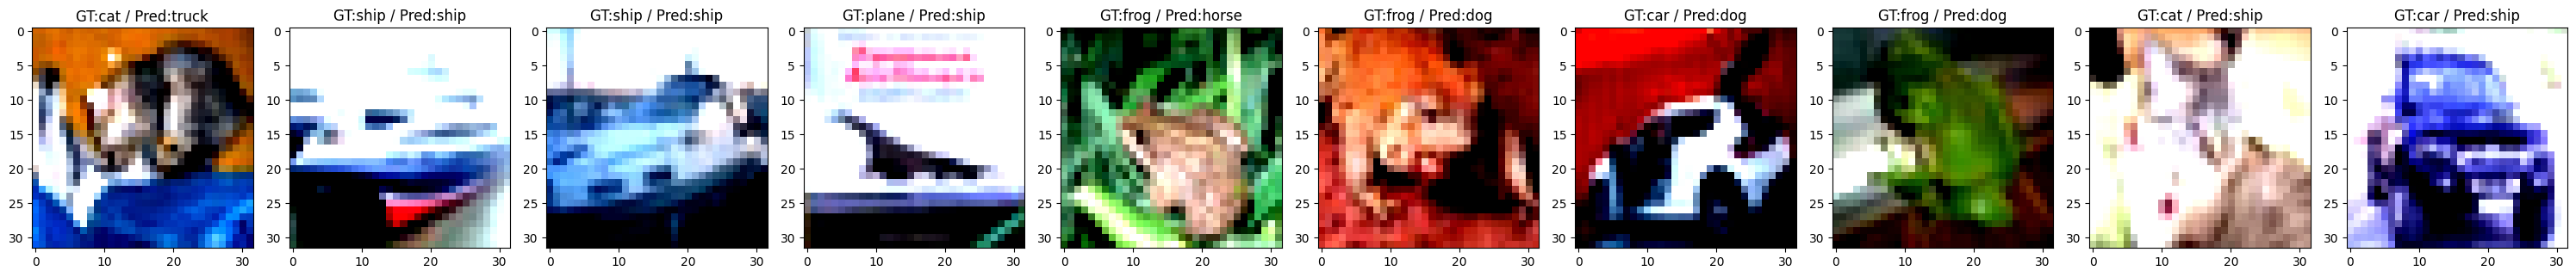

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def display_predictions(model, data_loader, device, classes, num_images=10):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)  # Use Python's built-in next() function
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(30,3))
    
    for i in range(num_images):
        img = images[i]  # get the image from the batch
        label = classes[labels[i]]  # get the label for the image
        pred = classes[predicted[i]]  # get the prediction for the image
        
        img = img / 2 + 0.5  # unnormalize
        npimg = img.cpu().numpy()
        ax = fig.add_subplot(1, num_images, i+1)
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f'GT:{label} / Pred:{pred}')

    plt.tight_layout()
    plt.show()
        
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
display_predictions(model_last, test_loader, device, classes, num_images=10)

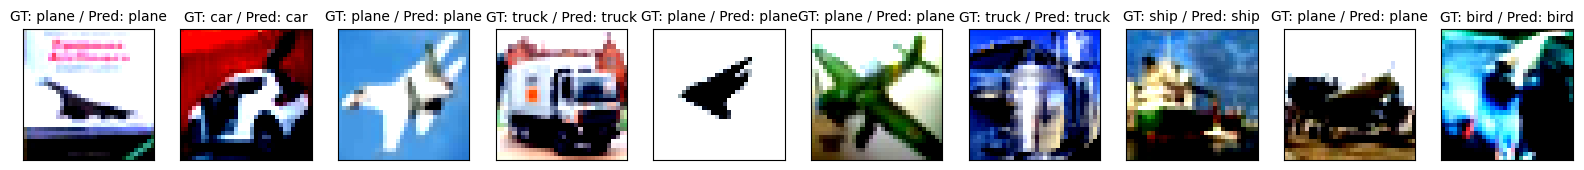

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def display_correct_predictions(model, data_loader, device, classes, num_images=10):
    data_iter = iter(data_loader)
    correct_counter = 0
    images_to_plot = []
    predicted_labels = []
    true_labels = []

    while correct_counter < num_images:
        images, labels = next(data_iter)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(images.size(0)):  # Iterate over each image in the batch
            if predicted[i] == labels[i]:  # If the prediction is correct
                # Add the image and labels to our lists
                images_to_plot.append(images[i].cpu())
                predicted_labels.append(predicted[i].cpu())
                true_labels.append(labels[i].cpu())
                correct_counter += 1
            if correct_counter == num_images:
                break

    # Now that we have our images and labels, we can plot them
    fig = plt.figure(figsize=(20,20))
    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i+1, xticks=[], yticks=[])
        imshow(images_to_plot[i], ax)
        ax.set_title(f'GT: {classes[true_labels[i]]} / Pred: {classes[predicted_labels[i]]}', fontsize=10)

def imshow(img, ax):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
display_correct_predictions(model_last, test_loader, device, classes, num_images=10)
